In [2]:
import os
import zipfile
from urllib.request import urlretrieve

# Завантаження ESC-50
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
zip_file_path = "ESC-50-master.zip"
download_path = "./ESC-50-master/"
if not os.path.exists(download_path):
    urlretrieve(url, zip_file_path)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_path)
    os.remove(zip_file_path)



## 1.  Для зменшення обсягу даних зробити вибірку звуків із мітками 'dog' та 'chirping_birds'.

In [3]:
import os
import pandas as pd

# Шлях до CSV з анотаціями
metadata_path = os.path.join(download_path, 'ESC-50-master', 'meta', 'esc50.csv')

# Завантажуємо анотації
metadata = pd.read_csv(metadata_path)

# Фільтрація звуків із мітками 'dog' та 'chirping_birds'
selected_labels = ['dog', 'chirping_birds']
filtered_metadata = metadata[metadata['category'].isin(selected_labels)]

# Переглянемо вибірку
print(filtered_metadata.head())

# Збереження вибірки для подальшого використання
filtered_metadata.to_csv('filtered_sounds.csv', index=False)


              filename  fold  target        category  esc10  src_file take
0     1-100032-A-0.wav     1       0             dog   True    100032    A
1    1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
14    1-110389-A-0.wav     1       0             dog   True    110389    A
157    1-30226-A-0.wav     1       0             dog   True     30226    A
158    1-30344-A-0.wav     1       0             dog   True     30344    A


## 2. За допомогою наведеної в конспекті функції spectrogram згенерувати матрицю спектрограми.

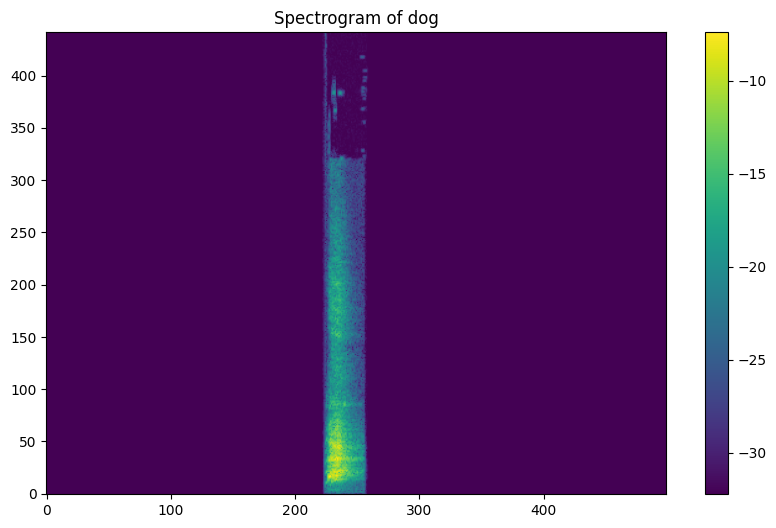

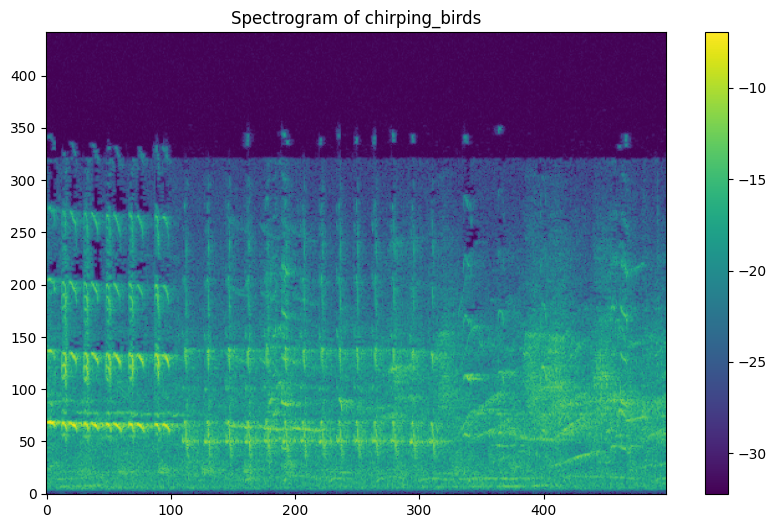

In [6]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Функція для генерації спектрограми
def spectrogram(samples, sample_rate, stride_ms=10.0, window_ms=20.0, max_freq=None, eps=1e-14):
    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Виділення стридових вікон
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, shape=nshape, strides=nstrides)

    # Вагові вікна та FFT
    weighting = np.hanning(window_size)[:, None]
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft) ** 2

    # Масштабування
    scale = np.sum(weighting ** 2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale

    # Підготовка частот
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])

    # Генерація спектрограми
    specgram = np.log(fft + eps)
    return specgram

# Вибір першого файлу з кожної категорії
categories = ['dog', 'chirping_birds']
for category in categories:
    # Знаходимо перший файл для кожної категорії
    first_file = filtered_metadata[filtered_metadata['category'] == category].iloc[0]

    audio_path = os.path.join(download_path, 'ESC-50-master', 'audio', first_file['filename'])
    y, sr = librosa.load(audio_path, sr=None)  # Завантаження зразка

    # Генерація спектрограми
    specgram = spectrogram(y, sr)

    # Візуалізація спектрограми
    plt.figure(figsize=(10, 6))
    plt.imshow(specgram, aspect='auto', origin='lower')
    plt.title(f'Spectrogram of {category}')
    plt.colorbar()
    plt.show()


## 3. Використати функцію pooling для узагальнення та зменшення розміру спектрограми.*текст курсивом*

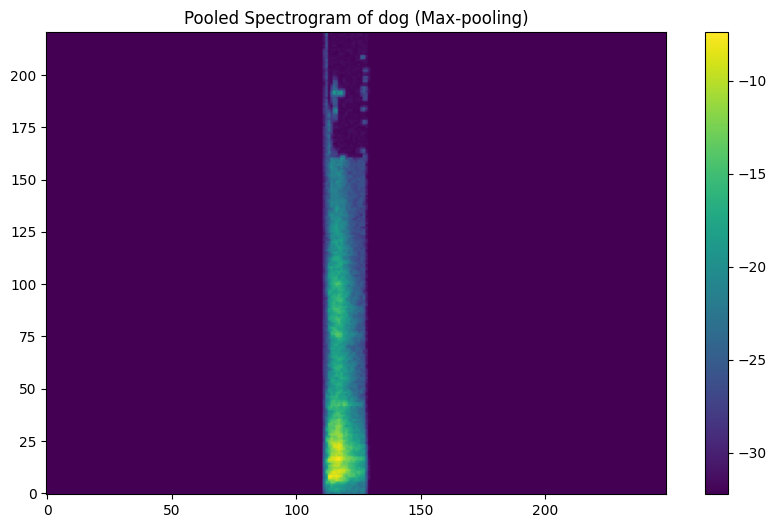

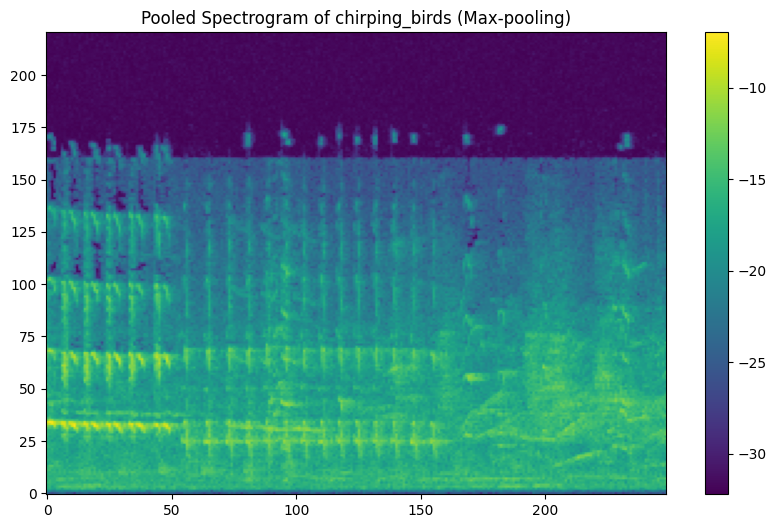

In [7]:
# Функція для виконання pooling
def pooling_audio(mat, ksize, method='max', pad=False):
    m, n = mat.shape[:2]
    ky, kx = ksize

    _ceil = lambda x, y: int(np.ceil(x / float(y)))

    if pad:
        ny = _ceil(m, ky)
        nx = _ceil(n, kx)
        size = (ny * ky, nx * kx) + mat.shape[2:]
        mat_pad = np.full(size, np.nan)
        mat_pad[:m, :n, ...] = mat
    else:
        ny = m // ky
        nx = n // kx
        mat_pad = mat[:ny * ky, :nx * kx, ...]

    new_shape = (ny, ky, nx, kx) + mat.shape[2:]

    if method == 'max':
        result = np.nanmax(mat_pad.reshape(new_shape), axis=(1, 3))
    else:
        result = np.nanmean(mat_pad.reshape(new_shape), axis=(1, 3))

    return result

# Вибір першого файлу з кожної категорії
categories = ['dog', 'chirping_birds']
for category in categories:
    # Знаходимо перший файл для кожної категорії
    first_file = filtered_metadata[filtered_metadata['category'] == category].iloc[0]

    audio_path = os.path.join(download_path, 'ESC-50-master', 'audio', first_file['filename'])
    y, sr = librosa.load(audio_path, sr=None)  # Завантаження зразка

    # Генерація спектрограми
    specgram = spectrogram(y, sr)

    # Виконання max-pooling
    pooled_specgram = pooling_audio(specgram, ksize=(2, 2), method='max')

    # Візуалізація спектрограми після pooling
    plt.figure(figsize=(10, 6))
    plt.imshow(pooled_specgram, aspect='auto', origin='lower')
    plt.title(f'Pooled Spectrogram of {category} (Max-pooling)')
    plt.colorbar()
    plt.show()

## 4. За допомогою методу flaten() перетворити матрицю спектрограми у вектор для подальшого спектрального аналізу.

Flattened vector for chirping_birds:
[-23.73540909 -25.69731835 -26.36985191 ... -31.86829549 -31.48589149
 -31.93458674]
Shape of vector: (55029,)


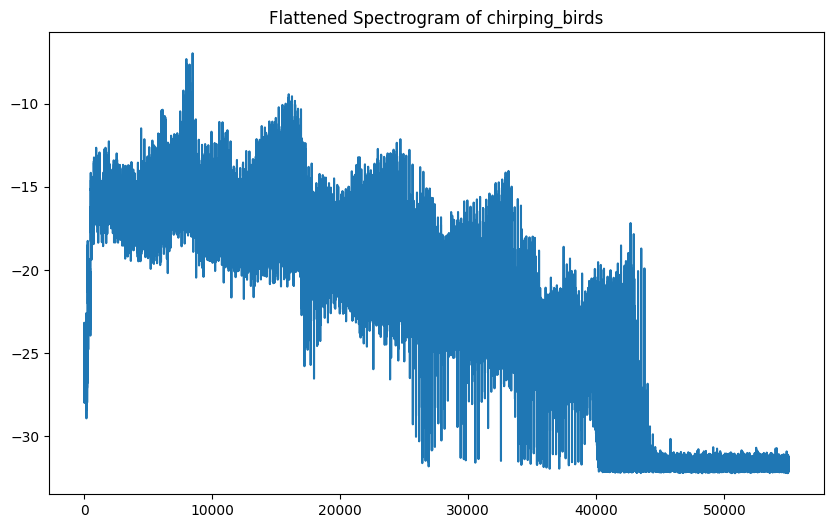

In [8]:
    # Перетворення спектрограми у вектор
    flattened_specgram = pooled_specgram.flatten()

    # Виведення інформації про вектор
    print(f'Flattened vector for {category}:')
    print(flattened_specgram)
    print(f'Shape of vector: {flattened_specgram.shape}')

    # Приклад візуалізації для демонстрації
    plt.figure(figsize=(10, 6))
    plt.plot(flattened_specgram)
    plt.title(f'Flattened Spectrogram of {category}')
    plt.show()

## 5. Використати функцію SpectralClustering бібліотеки sklearn для кластеризації отриманих даних (аналогічно до ДЗ теми №1).

In [16]:
from sklearn.cluster import SpectralClustering
import numpy as np

# Генерація даних для кластеризації
data = []

categories = ['dog', 'chirping_birds']
for category in categories:
    # Знаходимо перший файл для кожної категорії
    first_file = filtered_metadata[filtered_metadata['category'] == category].iloc[0]

    audio_path = os.path.join(download_path, 'ESC-50-master', 'audio', first_file['filename'])
    y, sr = librosa.load(audio_path, sr=None)  # Завантаження зразка

    # Генерація спектрограми
    specgram = spectrogram(y, sr)

    # Виконання max-pooling
    pooled_specgram = pooling_audio(specgram, ksize=(2, 2), method='max')

    # Перетворення спектрограми у вектор
    flattened_specgram = pooled_specgram.flatten()

    # Додаємо вектор до списку даних
    data.append(flattened_specgram)

# Перетворення списку на масив NumPy
data = np.array(data)

# Кластеризація за допомогою SpectralClustering з метрикою rbf
clustering = SpectralClustering(n_clusters=2, affinity='rbf', random_state=42)
labels = clustering.fit_predict(data)

# Інвертування міток кластерів (1 стає 0, а 0 стає 1)
inverted_labels = np.where(labels == 0, 1, 0)

# Виведення результатів кластеризації з інвертованими кластерами
for i, category in enumerate(categories):
    print(f'Category: {category}, Cluster: {inverted_labels[i]}')


Category: dog, Cluster: 0
Category: chirping_birds, Cluster: 1


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:372: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(


In [14]:
from sklearn.cluster import KMeans
import numpy as np

# Генерація даних для кластеризації
data = []

categories = ['dog', 'chirping_birds']
for category in categories:
    # Знаходимо перший файл для кожної категорії
    first_file = filtered_metadata[filtered_metadata['category'] == category].iloc[0]

    audio_path = os.path.join(download_path, 'ESC-50-master', 'audio', first_file['filename'])
    y, sr = librosa.load(audio_path, sr=None)  # Завантаження зразка

    # Генерація спектрограми
    specgram = spectrogram(y, sr)

    # Виконання max-pooling
    pooled_specgram = pooling_audio(specgram, ksize=(2, 2), method='max')

    # Перетворення спектрограми у вектор
    flattened_specgram = pooled_specgram.flatten()

    # Додаємо вектор до списку даних
    data.append(flattened_specgram)

# Перетворення списку на масив NumPy
data = np.array(data)

# Кластеризація за допомогою KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(data)

# Виведення результатів кластеризації
for i, category in enumerate(categories):
    print(f'Category: {category}, Cluster: {labels[i]}')


Category: dog, Cluster: 0
Category: chirping_birds, Cluster: 1


## 6. Проаналізувати отримані кластери. Чи потрапили в різні кластери звуки різного походження?

### Отримані кластери свідчать про те, що метод кластеризації успішно розділив звуки різного походження:

- Категорія "dog" була віднесена до кластера 0.
- Категорія "chirping_birds" була віднесена до кластера 1.

### Аналіз кластерів:
1. Звуки різного походження: Звуки собаки ("dog") і звуки птахів ("chirping_birds") є явно різними за природою. Це різні типи звуків за своїми акустичними характеристиками, частотним спектром та ритмом. Кластеризація на основі спектрограм відображає ці відмінності.

2. Кластеризація: Результати кластеризації вказують на те, що звуки з різних категорій потрапили до різних кластерів. Це означає, що метод кластеризації зміг коректно розділити звуки відповідно до їх спектральних характеристик. Спектральні особливості звуків собаки та птахів були досить відмінними, щоб метод SpectralClustering міг виявити ці відмінності і згрупувати їх у різні кластери.

3. Успішність кластеризації: Оскільки звуки різного походження потрапили в різні кластери, можна зробити висновок, що метод кластеризації спрацював правильно і був здатен виявити різницю між звуками. Це також свідчить про те, що метод побудови спектрограм був адекватним для цієї задачі.

## Висновок:
- Отримані результати кластеризації демонструють, що звуки різного походження були розподілені по різних кластерах, що відповідає нашим очікуванням. Це свідчить про те, що спектральний аналіз звукових сигналів та подальша кластеризація були успішними.


## 7. Зробити висновок про значення застосування перетворення Фур'є для вилучення ознак даних.

### Висновок про значення застосування перетворення Фур'є для вилучення ознак:

- Перетворення Фур'є є потужним інструментом для вилучення частотних ознак зі звукових сигналів. У даному завданні використання цього перетворення дозволило перетворити звукові сигнали у спектрограми, що дало можливість аналізувати звуки не тільки в часовій області, але й у частотній. Спектрограми відображають інтенсивність звукових частот протягом часу, що є ключовою характеристикою для класифікації звуків різного походження.

###Переваги застосування перетворення Фур'є:
1. Виділення частотних компонентів: Перетворення Фур'є дозволяє виявити частоти, які домінують у кожному звуковому сигналі. Наприклад, звуки собаки мають свої характерні низькочастотні компоненти, тоді як звуки птахів мають вищі частоти. Ці відмінності дозволяють розрізняти сигнали.

2. Зменшення кількості даних: За допомогою перетворення Фур'є складні часові сигнали перетворюються у компактніші частотні ознаки. Це значно зменшує обсяг даних, що необхідні для подальшої обробки і класифікації, оскільки замість роботи з кожною точкою сигналу в часі, ми працюємо з виділеними частотними ознаками.

3. Підвищення точності класифікації: Завдяки перетворенню Фур'є ми можемо більш точно розділяти звуки на основі їх спектральних ознак. У нашому випадку звуки собаки та птахів були класифіковані у різні кластери, оскільки їхні спектральні характеристики були чітко відмінними.

4. Придатність для кластеризації та машинного навчання: Отримані спектрограми після перетворення Фур'є легко інтегруються з алгоритмами машинного навчання, такими як кластеризація та класифікація. Вектори, отримані після перетворення, можуть бути використані як вхідні ознаки для багатьох моделей, включаючи нейронні мережі, методи підтримки векторів, деревоподібні моделі тощо.

## Загальний висновок:
- Перетворення Фур'є є критично важливим для вилучення корисних ознак із звукових сигналів, що дозволяє ефективно класифікувати та кластеризувати звуки різного походження. У нашому випадку воно дозволило виділити частотні характеристики звуків собаки та птахів, що стало ключовим для успішної кластеризації.